---

# CSCI 3202, Spring 2023
# Homework 3
# Due: Monday, March 6, 2023 at 9:00 PM

<br> 

### Your name: Kevin Jacob

<br> 

---

Some useful packages and libraries:



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from collections import deque
import heapq
import unittest
from scipy import stats
import copy as cp
from time import time

---

## Problem 1:  Calibrating a model for global mean sea level changes (75 points)

<img src="http://www.anthropocenemagazine.org/wp-content/uploads/2017/05/future-sea-levels.jpg" width="250">

**Part A:** Load and plot some data.

Let's load a couple of data sets.  `data_sealevel.csv` is a data set of global mean sea levels, and the other, `data_temperature.csv` is a data set of global mean temperatures. The following bullets discuss the quantities of interest. 
* `sealevel` will be a list of global mean sea levels (millimeters). This data is found in a column which resides within the `data_sealevel.csv`
* `sealevel_sigma` will be a list of the *uncertainty* in global mean sea levels (millimeters). Use the column labeled `uncertainty` within the `data_sealevel.csv` file to obtain this data, and
* `temperature` will be a list of global mean temperatures (degrees Celsius). This data is in the `temperature` column in the `data_temperature.csv` file


In [2]:
# Here is the suggested code to load in the data files. Feel free to modify these as you wish, but that
# is not necessary.

year = []
sealevel = []
sealevel_sigma = []
temperature = []

dfSealevel = pd.read_csv("data_sealevel.csv")
dfTemperature = pd.read_csv("data_temperature.csv")

# We aren't doing any heavy-duty stats stuff, so let's just keep what we need as regular lists
year = dfSealevel["year"].tolist()
sealevel = dfSealevel["sealevel"].tolist()
sealevel_sigma = dfSealevel["uncertainty"].tolist()
temperature = dfTemperature["temperature"].tolist()

**Part A (i):** (15 points)

- Make three plots for Global mean surface temperature, Sea level (mm), and Sea Level Uncertainty (mm). The x-axis for each of these plots will be the years over which this data was collected.

- <b>Use the following documentation to help you (Hint: The examples are SUPER helpful!):<b> 
    - subplot function: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
    - within the subplot parameters, there is "**figkw" (figure keywords):
    https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html#matplotlib.pyplot.figure
    - scatter function:
    https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html

- Plot the data points as a scatter plots, and plot the three plots side-by-side-by-side (one row, three columns of figures). The point here is learn how to customize your figures a bit more, and also because computer screens are (typically) wider than they are tall.

- You must include x-axis and y-axis labels with the appropriate unit in the label for each graph.

[Text(0.5, 0, 'Year'), Text(0, 0.5, 'Temperature')]

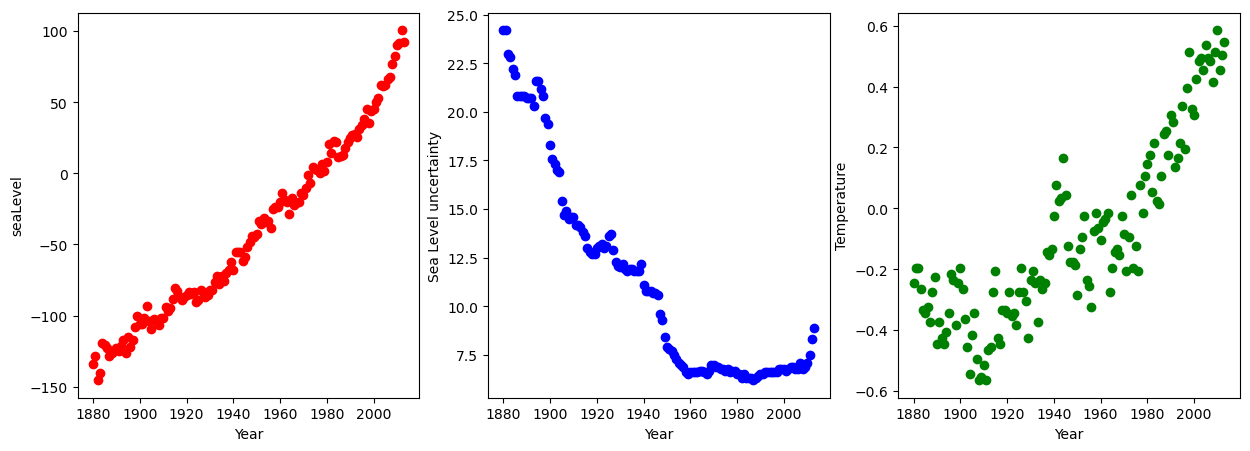

In [3]:
# Your plotting code here.
# When using the subplot function, set the "figsize" parameter (this is a figure keyword) to (18,4).
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))


#plt.figure(figsize=(18,4))
ax1.scatter(year,sealevel, color = 'red')
ax1.set(xlabel="Year", ylabel="seaLevel")

#ax2.subplot(1,3,2)
ax2.scatter(year,sealevel_sigma, color = 'blue')
ax2.set(xlabel="Year", ylabel="Sea Level uncertainty")


#plt.subplot(1,3,3)
#plt.figure(figsize=(18,4))
ax3.scatter(year,temperature, color='green')
ax3.set(xlabel="Year", ylabel="Temperature")


**Part A (ii):** (3 points) How does the uncertainty in global mean sea levels change as a function of time?  When is the uncertainty the highest?  Give one reason why you think this might be the case.

---

**Part B:** (10 points) The "out-of-box" sea-level model

In your plot from **(a)**, you should see quite an apparent relationship between increasing temperatures and rising sea levels.  Seems like someone should try to model the relationship between those two, huh?

In the helper function, slr, below, a simple model for temperature-driven changes in global mean sea level (GMSL) is defined. This is the model of [Rahmstorf (2007)](http://science.sciencemag.org/content/315/5810/368).

The `slr` model takes two parameters, $\alpha$ and $T_{eq}$, and requires a time series of global mean temperatures: `slr(alpha, Teq, temperature)`.
* `alpha` is the sensitivity of sea-level changes to changes in global temperature. The units for $\alpha$ are millimeters of sea-level changes per year, or mm y$^{-1}$.
* `Teq` is the equilibrium global mean temperature, with units of degrees Celsius.
* `temperature` is the time series of global mean surface temperatures, assumed to be relative to the 1961-1990 mean.

For now, you do not need to worry too much about how this model works.  It is very simple, and widely used, but the point here is that you can plug in a particular set of temperatures (the model **forcing**) and parameters ($\alpha$ and $T_{eq}$), and out pops a time series of simulated global mean sea levels.

**Our goal:**  Pick good values for $\alpha$ and $T_{eq}$, so that when we run the `slr` model using the observations of temperature (which we plotted above), the model output matches well the observations of global mean sea level (which we also plotted above).

The whole process of figuring out what these good parameter values are is called **model calibration**, and it's awesome.  
Let's have a look at why we need to do this in the first place, shall we?

The default parameter choices given in the Rahmstorf (2007) paper are $\alpha=3.4$ mm y$^{-1}$ and $T_{eq} = -0.5\ ^{\circ}$C.

**Your task for Part B:**

Make a plot that contains:
* the observed sea level data as scatter points
* the modeled sea levels as a line, using the temperature observations from above as the `temperature` input
* an appropriate legend and axis labels
* $x$ axis is years, $y$ axis is sea level

Note that after you run the `slr` model, you will need to **normalize** the output relative to the 1961-1990 reference period.  That is because you are going to compare it against data that is also normalized against this reference period. The `years` that correspond to the model output should be the same as the `years` that correspond to the `temperature` input. 

Normalizing data can mean several things. Follow the steps outlined below to "normalize" the data in the way needed for this problem:
- Compute the mean of the output of the slr model for the years from 1961-1990 (inclusive).
- Subtract this value from each entry in the "sealevel" list (list returned by the slr function)


Make sure that you normalize the data prior to plotting.

In [4]:
# helpers

def slr(alpha, Teq, temperature):
    '''sea-level emulator of Rahmstorf 2007 (DOI: 10.1126/science.1135456)
    Takes global mean temperature as forcing, and parameters:
    alpha = temperature sensitivity of sea level rise, and
    Teq   = equilibrium temperature,
    and returns a list containing values that reflect a rise/fall in sea levels, based on whether the temperature
    is warmer/cooler than the equilibrium temperature Teq.
    Here, we are only worrying about alpha (for now!)
    '''

    n_time = len(temperature)
    deltat = 1
    sealevel = [0]*n_time
    sealevel[0] = -134
    for t in range(n_time-1):
        sealevel[t+1] = sealevel[t] + deltat*alpha*(temperature[t]-Teq)

    return sealevel

def normalize(X, l=None, u=None):
    ''' X is the data to be normalized, l is the lower bound from where normalization should oriented, u is end of that orient
    '''
    if (not l and not u):
        l = 0
        u = len(X)
    avg = sum(X[l:u])/len(X[l:u])
    norms = [(x-avg) for x in X]
    return norms

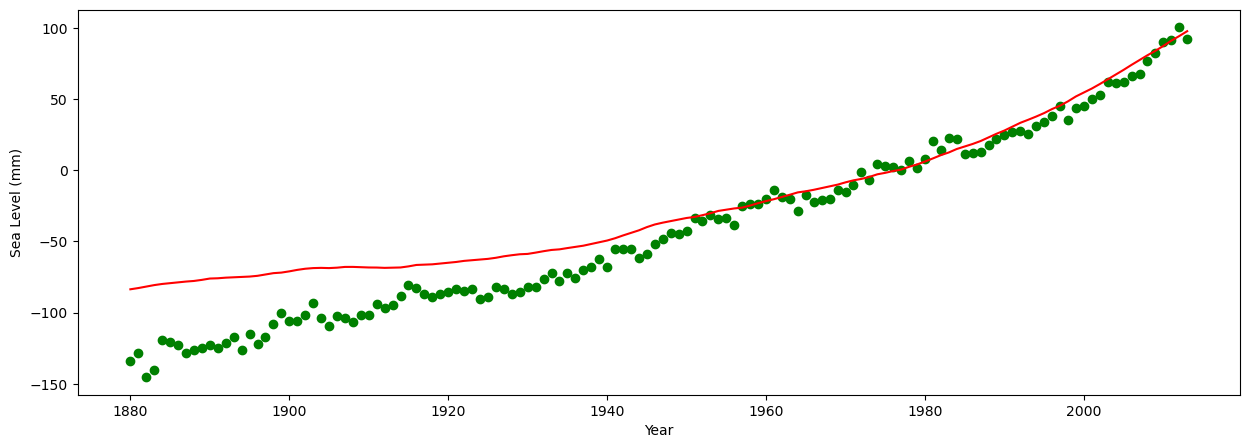

In [5]:
# Your code here. You can use the subplots function to create your graph 
# as you did in the previous question. Remember to NORMALIZE before plotting!
alpha = 3.4
Teq = -0.5

fig, (ax1) = plt.subplots(1, 1, figsize=(15, 5))

sixty = year.index(1961)
ninty = year.index(1990)

model = slr(alpha, Teq, temperature=temperature)
mean = sum(model[sixty:ninty]) / len(model[sixty:ninty])
normalizedModel = [modelNum - mean for modelNum in model]

ax1.scatter(year, sealevel, color = 'green')
ax1.set(xlabel="Year", ylabel="Sea Level (mm)")
ax1.plot(year, normalizedModel, color = 'red')

Your plot above ought to show decent match for the late 1900s, but diverge a bit further back in time.

**The point:**  We can do better than this "out-of-the-box" version of the Rahmstorf sea level model.

**Part C:**  Figuring out our objective function

As our **objective function**, we will use the joint likelihood function of the observed sea level data, given the model simulation.  The following is a detailed description of the derivation of the objective function for a hill climbing routine. 

**Note: you do not need to do anything for this part other than to read about the objective function and execute the cell below, then move to part D.**

For a single data point in year $i$, $y_i$, with associated uncertainty $\sigma_i$, we can assume the likelihood for our model simulation in year $i$, $\eta_i$, follows a normal distribution centered at the data point.  The model simulation is a **deterministic** result of our parameter choices $\alpha$ and $T_{eq}$, so we write the likelihood as:

$$L(y_i \mid \alpha, T_{eq}) = \dfrac{1}{\sqrt{2 \pi} \sigma_i} e^{-\dfrac{(\eta_i(\alpha, T_{eq}) - y_i)^2}{2\sigma_i^2}}$$

But that only uses a single data point.  Let's use all the data!  The **joint likelihood** is the product of all of the likelihoods associated with the individual data points. But that is the product of a lot of numbers that are less than 1, so it will be **tiny**.  Instead, we should try to optimize the **joint log-likelihood**, which is simply the (natural) logarithm of the joint likelihood function.

If we assume the observational data ($y_i$) are all independent, then the joint log-likelihood is:

$$l(\mathbf{y} \mid \alpha, T_{eq}) = -\dfrac{N}{2} \log{(2\pi)} - \sum_{i=1}^N \log{(\sigma_i)} - \dfrac{1}{2}\sum_{i=1}^N \left( \dfrac{\eta_i(\alpha, T_{eq}) - y_i}{\sigma_i} \right)^2$$

where, $\mathbf{y} = [y_1, y_2, \ldots, y_N]$ is the entire vector (list) of sea level observations, $\eta(\alpha, T_{eq}) = [\eta_1(\alpha, T_{eq}), \eta_2(\alpha, T_{eq}), \ldots, \eta_N(\alpha, T_{eq})]$ is the entire vector (list) of `slr` model output when the parameter values $\alpha$ and $T_{eq}$ are used, and $N$ is the number of observations we have.

**Defining our objective function**

Now define a `log_likelihood(parameters, obs_mu, obs_sigma)` function:
* `parameters`: argument that is a list of two parameter values, $[\alpha, T_{eq}]$
  * within the likelihood function, you will need to generate the model simulation $\eta(\alpha, T_{eq})$ using the input `parameters`, for comparison against the observational data
* `obs_temp`: argument that is a time series (list) of observed global mean temperatures, that will be used to run the `slr` model. Provide a default value of `temperature` for this, because we only have one temperature data set to use, and we don't want to keep 
* `obs_mu`: argument that is a time series (list) of observed values, that will be used for comparison against the `model` output. Provide a default value of `sealevel` here, because we won't be changing the observational data.
* `obs_sigma`: argument that is a time series (list) of the corresponding uncertainties in the observational data. Simiarly, provide a default value of `sealevel_sigma` here, so we can avoid the tedious task of sending the data set into this function.
* all three of these inputs should be lists, and should be the same length
* this routine should return a **single** float number, that is the joint log-likelihood of the given `model` simulation.

In [6]:
# Here is the objective function. You will be using this function below when you code up hill-climbing and 
# simulated annealing routines.

def log_likelihood(parameters, obs_temp=temperature, obs_mu=sealevel, obs_sigma=sealevel_sigma):
    model = slr(alpha=parameters[0], Teq=parameters[1], temperature=temperature)
    
    # normalizeh
    reference = (year.index(1961), year.index(1990))
    model -= np.mean(model[reference[0]:(reference[1]+1)])

    return np.sum([np.log(stats.norm.pdf(x=model, loc=obs_mu, scale=obs_sigma))])

**Part D:** (20 points) Defining our class structure

Now we will apply a hill-climbing algorithm to tune the $\alpha$ and $T_{eq}$ parameters.

Using our in-class lecture notebook on hill-climbing as a guide, do the following:

* Define a `State` class with the following attributes:
    * parameters - a list initialized with the $\alpha$ and $T_{eq}$ values.
    * alpha - references the $\alpha$ value in the parameters list
    * Teq - references the $T_{eq}$ value in the parameters list
    * obj_val - calls the objective function using the parameters attribute
    
* Define a `Problem` class with the following attributes:
    * initial_state - holds the initial state given
    * current_state - holds the current state; initialize with the initial state 
    * objective_function - holds the objective_function
    * stepsize_alpha - holds the stepsize_alpha value
    * stepsize_Teq - holds the stepsize_Teq value
    and  with the following function:
    * moves() - returns a list containing all possible moves from the current state
    
* Define a `Problem_hillclimb` **sub-class** (https://pybit.es/articles/python-subclasses/) of the more general class `Problem`, with:
  * a function called `best_move` that returns 
      * the move that maximizes the objective function - i.e. a list containing the new $\alpha$ and $T_{eq}$ values
      * the corresponding objective function value for that move
      * Example: When I run the objective function for subtracting the stepsize $T_{eq}$ value from the current state's $T_{eq}$ value and keeping $\alpha$ constant, I get -300. Based on all the other objective function values for other moves, this is the best one. So I `return [self.current_state.alpha, self.current_state.Teq - stepsize_Teq], -300`.
  
* Define the `hill_climb` algorithm, with any necessary modifications (here, and in the above classes) for the new 2-dimensional state space.
  * `hill_climb(problem, n_iter)`:  arguments are a `Problem_hillclimb` object and number of iterations, `n_iter`
  * return a `State` that corresponds to the algorithm's guess at a global maximum
  * If the algorithm reaches `n_iter` iterations, have it print "reached `n_iter`" (Done for you).

In [7]:
# Your code here.
class State:
    def __init__(self, alpha=3.4,Teq=0.5, objective_function=log_likelihood):
        '''
        See above for attribute details.
        '''
        self.parameters = [alpha,Teq]
        self.alpha = alpha
        self.Teq = Teq
        self.obj_val = objective_function(self.parameters)
    
class Problem:
    def __init__(self, initial, objective_function, stepsize_alpha, stepsize_Teq):
        '''
        See above for attribute details.
        '''
        self.initial_state: State = initial
        self.current_state: State = initial
        self.objective_function = objective_function
        self.stepsize_alpha = stepsize_alpha
        self.stepsize_Teq = stepsize_Teq
    def moves(self):
        '''
        Populates the all_moves list with potential moves. Remember we are tuning
        both the alpha and Teq parameters, so don't focus on just trying to optimize
        one of these parameters.
        '''
        all_moves = []
        aMoves = [self.current_state.alpha + self.stepsize_alpha, self.current_state.alpha - self.stepsize_alpha, self.current_state.alpha]
        tMoves = [self.current_state.Teq + self.stepsize_Teq, self.current_state.Teq - self.stepsize_Teq,self.current_state.Teq]

        for i in aMoves:
            for j in tMoves: 
                # if (not(a == alphas[2] and t == teqs[2])) : all_moves.append([a,t])
                all_moves.append([i,j])
        
        return all_moves

class problem_hillclimb(Problem):
    def best_move(self):
        '''
        Calls the moves() function and returns the best move from its output.
        Also returns the corresponding objective function value for that move.
        '''
        allMoves = self.moves()
        moves = [self.objective_function(n) for n in allMoves]
        bestMove = max(moves)
        return allMoves[moves.index(bestMove)], bestMove
def hill_climb(problem, n_iter):
    '''
    Finds a best move and determines whether its objective function value
    is less than or equal to the current obj_val attribute. If so, return that current_state.
    If not, update the current_state's parameters, obj_val, alpha, and Teq parameters, and
    keep iterating. 
    '''
    for k in range(n_iter):
        
        nextMove, nextVal = problem.best_move()
        if nextVal <= problem.current_state.obj_val:
            return problem.current_state
        problem.current_state.alpha, problem.current_state.Teq= nextMove[0],nextMove[1]
        problem.current_state.parameters, problem.current_state.obj_val= nextMove, nextVal

    print('reached n_iter')
    return False

Now:
1. define an initial state object, using the default values from Rahmstorf 2007 as a starting point.
2. define a hill-climbing problem object, using this initial state, the log-likelihood objective function, and stepsize(s) of your choosing. (The stepsize(s) may require some playing around to find something you are happy with.)
3. ***hill-climb!!!*** Use a number of iterations that you deem appropriate. 

Play around until you have a simulation that you are happy with.  Then:
1. Print to screen the parameter values and corresponding log-likelihood value.
2. Compare this calibrated log-likelihood value to the "out-of-box" model (above).
3. Make a single plot (i.e. all 3 lines on one plot) of:
  * the sea level observations as scatter points
  * the uncalibrated model as one line
  * the calibrated model as another line
  * include axis labels and a legend
  
**"Unit tests":**
* As a benchmark, make sure that your log-likelihood is *at least* -500.
* Your calibrated (optimized) model simulation should be going straight through the data points.
* If this isn't the case, remember to normalize your model against the 1961-1990 reference period!

In [8]:
# Your code here.

# DOES NOT WORK

**Part E:** (20 points) Simulated annealing

Let's re-calibrate the `slr` model. This time, we will use **simulated annealing**. Again, using our in-class activity as a guide, do the following:

* Continue to use your `State` class above.
* Complete the `Problem_annealing` sub-class (already initialized) of the `Problem` class with:
  * method for `random_move`, to pick a random move **by drawing random samples from a multivariate normal distribution**. Please refer to this documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html .  You should use the `stepsize` attribute as the covariance (width) for this.
* Define the `simulated_annealing` algorithm, with any necessary modifications (here, and in the above classes) for the new 2-dimensional state space.
  * `simulated_annealing(problem, n_iter)`:  arguments are a `Problem_annealing` object and number of iterations, `n_iter`
  * return a `State` that corresponds to the algorithm's guess at a global maximum

Subject to the above constraints, you may implement these however you would like.

In [9]:
# Your code here.
class problem_anneal(Problem):
    def __init__(self, initial, objective_function, schedule_function, stepsize_alpha, stepsize_Teq):
        Problem.__init__(self, initial, objective_function, stepsize_alpha, stepsize_Teq)
        self.schedule_function = schedule_function

    def random_move(self):
        '''
        Uses the current_state parameters and a list containing the 
        stepsize_alpha and stepsize_Teq to call the multivariate normal function,
        which results in the next move. Also returns objective_function value
        of that move.
        '''
        cov = [[self.stepsize_alpha, 0],[0, self.stepsize_Teq]]
        next_move = stats.multivariate_normal.rvs(mean = [self.current_state.alpha, self.current_state.Teq], cov = cov)
        return State(next_move[0], next_move[1], self.objective_function), self.objective_function(next_move)

# provided temperature updating schedule - do not change.
def schedule(time):
    C = 20#
    p = 0.7#
    temperature = C/(time+1)**p
    
    return temperature
    
def simulated_annealing(problem, n_iter):
    '''
    Starts with a temperature. Uses random_move() to find the next move and next objective
    function value. Refer to the metropolis acceptance criterion
    (criterion = exp( -(objective(new) – objective(current)) / temperature)) to determine probability 
    of whether current_state parameters, alpha, and Teq are updated.
    '''
    for t in range(n_iter):
        curr = problem.current_state
        temperature = problem.schedule_function(t)
        nextMove, nextVal = problem.random_move()
        delt =  problem.current_state.obj_val - nextVal
        
        if delt < 0:
            problem.current_state = nextMove
            problem.current_state.objective_function = nextVal
        else:
            acceptTol = np.exp(-delt/temperature)
            
            tol = np.random.choice([True,False], p=[acceptTol, 1-acceptTol])
            
            if tol:
                problem.current_state = nextMove
                problem.current_state.objective_function = nextVal
            
                
    return problem.current_state

Now:
1. define an initial state object, using the default values from Rahmstorf 2007 as a starting point.
2. define a simulated annealing problem object, using this initial state, the log-likelihood objective function, an appropriate temperature updating schedule (Note: This has been provided!) and stepsize(s) of your choosing. (The stepsize(s) may require some playing around to find something you are happy with.)
  * note that this "temperature" is distinct from the actual physical temperature used as input to drive the `slr` model
3. ***anneal!!!*** Use a number of iterations that you deem appropriate. 

Play around until you have a simulation that you are happy with.  Then:
1. Print to screen the parameter values and corresponding log-likelihood value.
2. Compare this calibrated log-likelihood value to the "out-of-box" model (above).
3. Make a plot of:
  * the sea level observations as scatter points
  * the uncalibrated model as one line
  * the calibrated model as another line
  * include axis labels and a legend
  
**"Unit tests":**  How does your model look when you plot it against the data? If it doesn't look good, then you failed this unit test :(

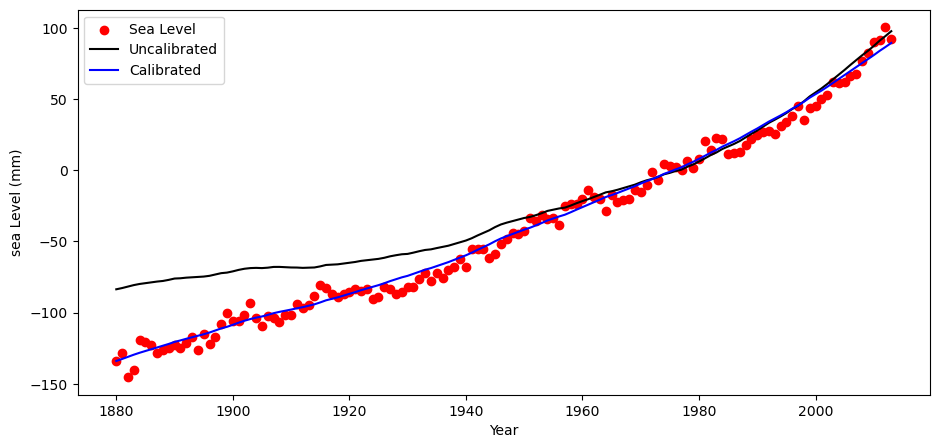

In [10]:
# Your code here.
initial_state = State()
anneal = problem_anneal(initial=initial_state, objective_function=log_likelihood, stepsize_alpha=.1, stepsize_Teq=.010, schedule_function = schedule)
annResult = simulated_annealing(anneal, 300)

annAlpha = annResult.alpha
annTeq = annResult.Teq

print(annResult)
# assert(log_likelihood([annAlpha, annTeq]) > -500)

fig, axes = plt.subplots(1, 1, figsize=(11, 5))

sixty = year.index(1961)
ninty = year.index(1990)

alpha = 3.4
Teq = -0.5
res = slr(alpha, Teq, temperature)
res3 = slr(annAlpha, annTeq, temperature)
normBase = normalize(res, sixty, ninty)
normOptAnn = normalize(res3, sixty, ninty)

if normBase != normOptAnn: newC = "black" 
else: newC = "green" 

axes.scatter(year, sealevel, color = 'red')
axes.set(xlabel="Year", ylabel="sea Level (mm)")
axes.plot(year, normBase, color = newC)
axes.plot(year, normOptAnn, color = 'blue')
axes.legend(["Sea Level", "Uncalibrated", "Calibrated"])

**Part F:** (10 points)

Briefly summarize your findings. Specifically discuss the $\alpha$ and $T_{eq}$ parameter values you found in **Part D** and **Part E**. How do these compare to the parameters of the model given by Rahmstorf? Did your hill-climbing and/or your simulated annealing programs find a better fit than the Rahmstorf model? 

Upon intial inspection, the hill climb and the simulated annealing both seem to be aligned the same. Both models tend to do a good job of illustrating the relationship between the data. An inspection I made was that the stepsize of the annealing when compared to the hill climb could be higher in order to obtain a minimum of greater than ~-500.

---

## Problem 2 (30 points extra credit): Maximizing an Objective Function with a Genetic Algorithm 

### Note: This problem is extra credit.  It is due at the same time as problem 1

Suppose we've lost the index card with our favorite cupcake recipe. We know the ingredients of the cake, but cannot remember the exact amount of each ingredient. We decide to use a genetic algorithm to generate the  ingredient amounts. With each iteration of the genetic algorithm, we bake the cupcakes and taste-test them. We achieve our goal and stop running the genetic algorithm when we get to the actual recipe: 

* 1 tsp salt 
* 3 tsp baking powder 
* 2 cups all-purpose flour 
* 1 cup butter 
* 1 cup granulated sugar 
* 4 large eggs
* 1 tsp vanilla extract
* 1 cup buttermilk 

In [11]:
target = [1, 3, 2, 1, 1, 4, 1, 1]

An example starting state for a member of our population might look like: $state = [1, 2, 100, 36, 60, 3, 5, 50]$, which is equivalent to 1 tsp salt, 2 tsp baking powder, 100 cups of flour, 36 cups of butter, 60 cups of granulated sugar, 3 large eggs, 5 tsp vanilla, and 50 cups of buttermilk.

### (2a) (10 points) 

Write an objective function `def recipe_success(state)` that takes a single argument state, and returns the objective function value (fitness) of the state. The objective function should be maximized when a state reaches the target.

Define the fitness score of a particular state based on how far away each entry is from the target recipe. 
Let the fitness goal be if the sum of the fitness values for all elements is equal to zero or if the reciprocal of the sum (1/sum) is greater than 1e10.

In [12]:
def recipe_success(state):
    # Your code here.


SyntaxError: incomplete input (3819022400.py, line 2)

In [ ]:
# Write your own test case to make sure that the target element achieves
# the fitness score you would expect it to (this will vary depending on
# what you did here.)

### (2b) (10 points) 

Write a genetic algorithm that starts with a population of 100 randomly generated "recipes/states" and uses the objective function you wrote in **(1a)** to hopefully hit the target after 50 generations. 

- Key component 1: The initial population contains 100 states. Each state has 8 elements. Each element should be generated randomly from integers between 0 and 100. 

- Key component 2: Create a class called "Problem" with the following attributes:
    - population - a list holding the states as they are updated. Initialized at the beginning with the initial_population parameter provided (done for you).
    - initial_population - a list holding the original 100 randomly generated states (done for you).
    - objective_function - use the function you wrote from part 1a, returns a fitness score of a particular state
    - p_mutute - probability to mutate
    - n_pop - number of states within initial_population
    - n_dna - number of elements within a state (i.e. the n_dna value for the example starting state from the recipe example above would be 8)
    - fitness_goal - a constant value; when the objective_function's performance output is greater than the fitness goal, then that state has reached its target
    
    and the following functions:
    
        - fitness()
        - reproduce(parent1, parent2)
        - mutate(child)

- Create a function called "genetic_algorithm" which takes in 2 parameters: an instance of the Problem class, and an integer called which represents the amount of iterations you want to run the algorithm for (50).
    - This function will use the Problem class and all functions within that class (fitness, reproduce, and mutate).
    - It will return a list representing the goal state (called best_member) and the number of iterations it took to find this state (called t).

In [ ]:
initial_population = []
# Create the initial population using Key Component 1 instructions
    
class Problem:
    def __init__(self, initial_population, objective_function, mutation_probability, fitness_goal):
# Define the attibutes of the Problem class using Key Component 2 instructions
        self.population = initial_population
        self.initial_population = initial_population
        
    def fitness(self):
""" - returns a list containing performance ratios of each element in the population attribute
    - a performance ratio = 
        (the objective function value for an individual element in the population attribute) / 
        (sum of all objective function values for all elements in population attribute)
"""
    
    def reproduce(self, parent1, parent2):
"""- takes in 2 parent lists, returns the child list
   - chooses a random number which represents an index to split each parent list by (i.e [:randomNum] and [randomNum:])
   - the child list is the concatenated/joined list of the two split parent lists from above
"""
    
    def mutate(self, child):
"""- takes in the child list, returns the mututed/changed child list 
   - chooses one random number representing an index in the child list
   - chooses one random integer (either 0 or 1/essentially "flip a coin")
   - If 0, divide the value located in the child list using the randomly chosen index by 2
   - If 1, add 5 to the value located in the child list using the randomly chosen index 
"""
        
def genetic_algorithm(Problem, n_iter):
"""
- This function will use the Problem class and all functions within that class (fitness, reproduce, and mutate).
- It will return a list representing the goal state (called best_member) and the number of iterations it took to find this state (called t).

- Runs for 50 iterations max or until fitness goal (in Problem class) is reached
    - Within each iteration, complete the following:
        - Create a new generation (i.e. an empty list to hold new states, called new_generation). (Done for you.)
        - We want to create n_pop (Problem attribute) new states
            - Start with fitness() call (Done for you.)
            - Randomly choose 2 "parent" lists (choose random indices!) from the population attribute (Problem class).
            - Use these two parent lists in the reproduce function (Problem class) to create a child.
            - Determine if the child will mutate using the p_mutate attribute (Problem class). 
              If so, call the mutate function. 
            - Append the child to the new generation (new_generation).
        - Update the population attribute to the new generation. (Done for you.)
        - Call the objective function on each element in the population attribute.
    - Choose 2 "parents" in the generation of each "child" (i.e. randomly choose 2 states from the initial population)    
"""
    best_member = None
    for t in range(n_iter):
        new_generation = []
        
        for k in range(Problem.n_pop):
            
            p_reproduce = Problem.fitness()
            

    print('reached n_iter')

    return best_member, t

### (2c) (10 points)

In a paragraph, report the following:
- How many generations did it take to hit the goal?
- If you change the initial population size to 200, does that change the number of generations it takes to achieve the goal recipe?
- If you change the probability of mutation, does that affect the number of generations it takes to achieve the goal recipe? How so?

<b>If Target was not hit answer these questions instead:<b>
- Report whether you minimized or maximized the objective function and whether that led to any major changes in how you designed the probability of reproduction. A couple sentences here is fine.
 
- Report how many ingredients you ended up matching. e.g. target = [0.5, 3, 2.5, 1, 1.5, 4, 1, 1.25], perhaps your algorithm achieved [1.5, 3, 8, 1, 1, 100, 56, 1, 1.25], then you would have matched 4 of the ingredient values.
 
- Report how many iterations you tried in order to get this answer. (Don't burn up your machine in the process)